# Addition experiment

An implementation of sequence to sequence learning for performing addition

* Input: "535+61"

* Output: "596"

Padding is handled by using a repeated sentinel character (space)
Input may optionally be inverted, shown to increase performance in many tasks in:
"Learning to Execute"
http://arxiv.org/abs/1410.4615
and
"Sequence to Sequence Learning with Neural Networks"
http://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf
Theoretically it introduces shorter term dependencies between source and target.
Two digits inverted:
+ One layer LSTM (128 HN), 5k training examples = 99% train/test accuracy in 55 epochs
Three digits inverted:
+ One layer LSTM (128 HN), 50k training examples = 99% train/test accuracy in 100 epochs
Four digits inverted:
+ One layer LSTM (128 HN), 400k training examples = 99% train/test accuracy in 20 epochs
Five digits inverted:
+ One layer LSTM (128 HN), 550k training examples = 99% train/test accuracy in 30 epochs

In [32]:
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *

import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'C:\\Users\\tumanov\\AppData\\Local\\Temp\\try_flags_ltil45h8.c:4:19: fatal error: cudnn.h: No such file or directory\r\ncompilation terminated.\r\n'
Mapped name None to device cuda0: GeForce GTX 1070 (0000:01:00.0)


## Utils

In [33]:
def non_trainable(net):
    for tags in net.params.values():
        tags -= {'trainable', 'regularizable'}
    return net

## Parameters

In [88]:
# Parameters for the model and dataset.
TRAINING_SIZE = 50000
DIGITS = 3
INVERT = True

In [89]:
# Try replacing GRU, or SimpleRNN.
HIDDEN_SIZE = 128

## Generating data

In [90]:
def generate_data(size, digits, problem = lambda a, b: a+b, problem_operator='{}+{}'):
    source_seqs = []
    target_seqs = []
    seen = set()
    print('Generating data...')
    while len(source_seqs) < TRAINING_SIZE:
        f = lambda: int(''.join(np.random.choice(list('0123456789'))
                        for i in range(np.random.randint(1, DIGITS + 1))))
        a, b = f(), f()
        # Skip any addition questions we've already seen
        # Also skip any such that x+Y == Y+x (hence the sorting).
        key = tuple(sorted((a, b)))
        if key in seen:
            continue
        seen.add(key)
        # Pad the data with spaces such that it is always MAXLEN.
        q = problem_operator.format(a, b)
        ans = str(problem(a, b))

        source_seqs.append(q)
        target_seqs.append(["START"] + list(ans) + ["END"])

    print('Total addition questions:', len(source_seqs))
    
    target_letters = list(set([token for ts in target_seqs for token in ts]))
    target_letter_to_ix = {ph:i for i,ph in enumerate(target_letters)}
    
    source_letters = list(set([token for word in source_seqs for token in word]))
    source_letter_to_ix = {l:i for i,l in enumerate(source_letters)}
    
    return np.array(source_seqs), source_letters, source_letter_to_ix, \
           np.array(target_seqs), target_letters, target_letter_to_ix

In [91]:
source_seqs, source_letters, source_letter_to_ix, target_seqs, target_letters, target_letter_to_ix =\
                    generate_data(TRAINING_SIZE, DIGITS)

Generating data...
Total addition questions: 50000


In [92]:
for source, target in zip(source_seqs[:5],target_seqs[:5]):
    print( source,':',"".join(target[1:-1]))

266+547 : 813
52+12 : 64
59+98 : 157
2+809 : 811
30+5 : 35


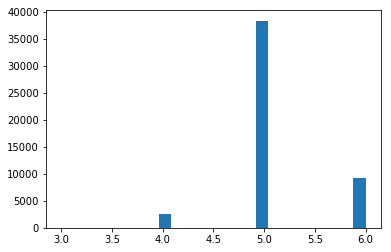

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len,target_seqs)),bins=25);

# Truncate names longer than MAX_LEN characters. This can be changed
MAX_LEN = min([150,max(list(map(len, target_seqs)))])

## Cast everything from symbols into matrix of int32. Pad with -1

In [94]:
def as_matrix(sequences, token_to_i, max_len=None, PAX_ix=-1):
    """
    Converts several sequences of tokens to a matrix, edible a neural network.
    Crops at max_len(if given), pads shorter sequences with -1 or PAD_ix.
    """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int8') -1
    for i,seq in enumerate(sequences):
        
        row_ix = [token_to_i.get(_, 0) for _ in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix


## Input vars

In [95]:
input_sequence = T.matrix('token sequence', 'int32')
output_sequence = T.matrix('target target_letters', 'int32')

## Classic model

In [96]:

##ENCODER
l_in = InputLayer(shape=(None, None),input_var=input_sequence)
l_mask = InputLayer(shape=(None, None),input_var=T.neq(input_sequence,-1)) 


l_emb = non_trainable(EmbeddingLayer(l_in, len(source_letters),  len(source_letters), W=np.diag(np.ones(len(source_letters)))))
l_rnn = LSTMLayer(l_emb, HIDDEN_SIZE, only_return_final=True, mask_input=l_mask)

In [97]:
##DECODER
dec_in = InputLayer(shape=(None, None),input_var=output_sequence)
dec_mask = InputLayer(shape=(None, None),input_var=T.neq(output_sequence,-1))

dec_emb = non_trainable(EmbeddingLayer(dec_in, len(target_letters), len(target_letters), W=np.diag(np.ones(len(target_letters)))))
dec_rnn = LSTMLayer(dec_emb, num_units=HIDDEN_SIZE, cell_init=l_rnn, mask_input=dec_mask)
# WARNING! if it's lstm use cell_init, not hid_init


#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
dec_rnn_flat = reshape(dec_rnn, (-1,dec_rnn.output_shape[-1]))

l_out = DenseLayer(dec_rnn_flat, len(target_letters), nonlinearity=lasagne.nonlinearities.softmax)

In [98]:
def handle_model(nn, learning_rate=0.001):
    # Model weights
    weights = get_all_params(nn)
    network_output = get_output(nn)
    network_output = network_output.reshape([output_sequence.shape[0],\
                                         output_sequence.shape[1], -1])
    predictions_flat = network_output[:,:-1,:].reshape([-1,len(target_letters)])
    targets = output_sequence[:,1:].ravel()

    #do not count loss for '-1' tokens
    mask = T.nonzero(T.neq(targets,-1))

    loss = lasagne.objectives.categorical_crossentropy(predictions_flat[mask], targets[mask]).mean()
    updates = lasagne.updates.adam(loss, weights, learning_rate=learning_rate)
    #training
    train = theano.function([input_sequence, output_sequence], loss, updates=updates, allow_input_downcast=True)

    #computing loss without training
    compute_cost = theano.function([input_sequence, output_sequence], loss, allow_input_downcast=True)
    #compile the function that computes probabilities for next token given previous text.

    last_probas =network_output[:, -1]

    probs = theano.function([input_sequence, output_sequence], last_probas)
    return train, compute_cost, probs

In [99]:
train, compute_cost, probs = handle_model(l_out)

# Generation

We now need to implement a function that generates output sequence given input.

Such function must work thusly:
```
Init:
x = input
y = ["START"]

While not_too_long:
  p(y_next|x,y) = probabilities of next letter for y
  
  y_next ~ p(y_next|x,y)
  
  y.append(y_next)
  
  if y_next == "END":
      break
```

In [100]:
def generate_output(input, probs, target_letters, target_letter_to_ix, source_letter_to_ix,
                    output_prefix = ("START",),
                    END_token="END",
                    temperature=1,
                    sample=True):
    
    """
    Implement a function that generates output sequence given input.
    
    We recommend (but not require) you to use the pseudo-code above and inline instructions.
    """
    x = as_matrix([input], source_letter_to_ix) 
    output = list(output_prefix)
    while True:
        y = as_matrix([output], target_letter_to_ix)
        next_y_probs = probs(x, y)
        next_y_probs = (next_y_probs ** temperature) / (next_y_probs ** temperature).sum()
        if sample:
            next_y = np.random.choice(target_letters, p=next_y_probs[0])
        else:
            next_y = target_letters[next_y_probs[0].argmax()]
        next_y = str(next_y)             
        assert type(next_y) is str, "please return token(string/character), not it's index"
        
        output.append(next_y)

        if next_y==END_token:
            break
            
    return output



## Model training

In [101]:
#source_seqs = np.array(source_seqs)
#target_seqs = np.array(target_seqs)

In [102]:
def sample_batch(source_seqs, source_letter_to_ix, target_seqs, target_letter_to_ix, batch_size):
    """samples a random batch of source and target sequences, batch_size elements"""
    batch_ix = np.random.randint(0,len(source_seqs),size=batch_size)
    source_seqs_batch=as_matrix(source_seqs[batch_ix], source_letter_to_ix) 
    target_seqs_batch=as_matrix(target_seqs[batch_ix], target_letter_to_ix)
    
    return source_seqs_batch,target_seqs_batch

In [103]:
#total N iterations
n_epochs=30

# how many minibatches are there in the epoch 
train_batches_per_epoch = 500
val_batches_per_epoch = 50

#how many training sequences are processed in a single function call
batch_size=64


train_source_seqs, val_source_seqs, train_target_seqs, val_target_seqs = train_test_split(source_seqs, target_seqs,\
                                                                                          test_size=0.33, random_state=42)

for epoch in range(n_epochs):
    try:

        train_avg_cost = 0;
        val_avg_cost = 0;

        for _ in range(train_batches_per_epoch):
            x,y = sample_batch(train_source_seqs, source_letter_to_ix, train_target_seqs, target_letter_to_ix, batch_size)
            train_avg_cost += train(x, y).mean()
        
        for _ in range(val_batches_per_epoch):
            x,y = sample_batch(val_source_seqs, source_letter_to_ix, val_target_seqs, target_letter_to_ix, batch_size)
            val_avg_cost += compute_cost(x, y).mean()

        print("Epoch {} train average loss = {}".format(epoch, train_avg_cost / train_batches_per_epoch))
        print("Epoch {} val average loss = {}".format(epoch, val_avg_cost / val_batches_per_epoch))
        
        for i in range(5):
            ind = np.random.randint(len(val_source_seqs))
            print (val_source_seqs[ind],':', ''.join(generate_output(val_source_seqs[ind], probs, target_letters, target_letter_to_ix, \
                                                             source_letter_to_ix, sample=True)[1:-1]),' | ', ''.join(val_target_seqs[ind][1:-1]))


    except KeyboardInterrupt:
        break

Epoch 0 train average loss = 1.724408619115944
Epoch 0 val average loss = 1.6007625962506895
625+968 : 632  |  1593
5+539 : 161  |  544
568+248 : 1049  |  816
734+723 : 1420  |  1457
86+350 : 594  |  436
Epoch 1 train average loss = 1.4482155305233033
Epoch 1 val average loss = 1.3316337735395296
10+463 : 536  |  473
4+549 : 517  |  553
33+990 : 1039  |  1023
326+58 : 311  |  384
767+18 : 833  |  785


## Bazal module

In [108]:
class CerMemory(lasagne.layers.Layer):
    def __init__(self, incoming, memory_size, M=lasagne.init.Orthogonal(), **kwargs):
        super(CerMemory, self).__init__(incoming, **kwargs)
        self.query_shape = self.input_shape[1]
        self.memory_size = memory_size
        self.M = self.add_param(M, (self.query_shape, memory_size), name='M')

    def get_output_for(self, input, **kwargs):
        m = self.M / T.sqrt(T.sqr(self.M).sum(axis=0)).reshape(self.M.shape[1], 1)
        weights =  T.dot(input, m)
        return T.dot(weights, m.T)
    
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.query_shape)

In [109]:
class EvcNormalizer(lasagne.layers.Layer):
    def get_output_for(self, input, **kwargs):
        return (input.T / T.sqrt(T.sqr(input).sum(axis=1)).reshape(input.shape[0], 1)).T

In [110]:
QUERY_SIZE = 16
MEMORY_SIZE = 64
HIDDEN_SIZE = 128

In [111]:
def bazal_model(query_size, memory_size, hidden_size, memory_benchmark=False, bidir_features=False):

    ##ENCODER
    l_in = InputLayer(shape=(None, None),input_var=input_sequence)
    l_mask = InputLayer(shape=(None, None),input_var=T.neq(input_sequence,-1)) 


    l_emb = non_trainable(EmbeddingLayer(l_in, len(source_letters),  len(source_letters), W=np.diag(np.ones(len(source_letters)))))

    features = LSTMLayer(l_emb, HIDDEN_SIZE, only_return_final=True, mask_input=l_mask)
    features_backward = LSTMLayer(l_emb, HIDDEN_SIZE, only_return_final=True, mask_input=l_mask, backwards=True)
    if bidir_features:
        features = ConcatLayer([features, features_backward])
    
    if not memory_benchmark:
        ## QUERY BUILDER
        query = DenseLayer(features, QUERY_SIZE, nonlinearity=None)
        query = EvcNormalizer(query)
        ## Memory
        memory = CerMemory(query, MEMORY_SIZE)
    else:
        memory = DenseLayer(DenseLayer(features, QUERY_SIZE), QUERY_SIZE)
        
    to_decode = ConcatLayer([features, memory])
    
    ##DECODER
    dec_in = InputLayer(shape=(None, None),input_var=output_sequence)
    dec_mask = InputLayer(shape=(None, None),input_var=T.neq(output_sequence,-1))

    dec_emb = non_trainable(EmbeddingLayer(dec_in, len(target_letters), len(target_letters), W=np.diag(np.ones(len(target_letters)))))
    dec_rnn = LSTMLayer(dec_emb, num_units=to_decode.output_shape[-1], cell_init=to_decode, mask_input=dec_mask)
    # WARNING! if it's lstm use cell_init, not hid_init


    #flatten batch and time to be compatible with feedforward layers (will un-flatten later)
    dec_rnn_flat = reshape(dec_rnn, (-1,dec_rnn.output_shape[-1]))

    l_out = DenseLayer(dec_rnn_flat, len(target_letters), nonlinearity=lasagne.nonlinearities.softmax)
    return l_out, memory

In [112]:
l_out, memory = bazal_model(QUERY_SIZE, MEMORY_SIZE, HIDDEN_SIZE, False)

In [113]:
train, compute_cost, probs = handle_model(l_out)

In [114]:
#total N iterations
n_epochs=30

# how many minibatches are there in the epoch 
train_batches_per_epoch = 500
val_batches_per_epoch = 50

#how many training sequences are processed in a single function call
batch_size=64


train_source_seqs, val_source_seqs, train_target_seqs, val_target_seqs = train_test_split(source_seqs, target_seqs,\
                                                                                          test_size=0.33, random_state=42)

for epoch in range(n_epochs):
    try:

        train_avg_cost = 0;
        val_avg_cost = 0;

        for _ in range(train_batches_per_epoch):
            x,y = sample_batch(train_source_seqs, source_letter_to_ix, train_target_seqs, target_letter_to_ix, batch_size)
            train_avg_cost += train(x, y).mean()
        
        for _ in range(val_batches_per_epoch):
            x,y = sample_batch(val_source_seqs, source_letter_to_ix, val_target_seqs, target_letter_to_ix, batch_size)
            val_avg_cost += compute_cost(x, y).mean()

        print("Epoch {} train average loss = {}".format(epoch, train_avg_cost / train_batches_per_epoch))
        print("Epoch {} val average loss = {}".format(epoch, val_avg_cost / val_batches_per_epoch))
        
        for i in range(5):
            ind = np.random.randint(len(val_source_seqs))
            print (val_source_seqs[ind],':', ''.join(generate_output(val_source_seqs[ind], probs, target_letters, target_letter_to_ix, \
                                                             source_letter_to_ix, sample=True)[1:-1]),' | ', ''.join(val_target_seqs[ind][1:-1]))


    except KeyboardInterrupt:
        break

Epoch 0 train average loss = 1.6742143869203903
Epoch 0 val average loss = 1.4339063474449143
773+25 : 799  |  798
81+445 : 916  |  526
28+352 : 261  |  380
39+578 : 465  |  617
878+646 : 1523  |  1524
Epoch 1 train average loss = 1.317323833876064
Epoch 1 val average loss = 1.2285492045532798
351+682 : 1599  |  1033
640+67 : 640  |  707
96+906 : 1011  |  1002
406+521 : 792  |  927
715+561 : 1607  |  1276
Epoch 2 train average loss = 1.1632730232336268
Epoch 2 val average loss = 1.1099605287226941
86+350 : 399  |  436
286+3 : 336  |  289
8+342 : 332  |  350
759+18 : 788  |  777
290+290 : 513  |  580
Epoch 3 train average loss = 1.045522278657902
Epoch 3 val average loss = 0.9992109939609599
438+11 : 437  |  449
56+392 : 428  |  448
17+300 : 305  |  317
33+557 : 523  |  590
80+45 : 129  |  125
Epoch 4 train average loss = 0.9506064003860062
Epoch 4 val average loss = 0.9316100418117856
3+951 : 957  |  954
629+8 : 635  |  637
639+39 : 693  |  678
153+4 : 176  |  157
219+104 : 320  |  323

In [41]:
M_add = np.array(memory.M.eval())

In [43]:
np.save('./zoo/addprob_memory_after30epochs.npy', M_add)

## Same for prod problem

In [115]:
TRAINING_SIZE = 100000
DIGITS = 3

In [116]:
source_seqs, source_letters, source_letter_to_ix, target_seqs, target_letters, target_letter_to_ix =\
                    generate_data(TRAINING_SIZE, DIGITS, lambda a, b: a * b, '{}*{}')

Generating data...
Total addition questions: 100000


In [117]:
for source, target in zip(source_seqs[:5],target_seqs[:5]):
    print( source,':',"".join(target[1:-1]))

25*43 : 1075
61*4 : 244
3*184 : 552
7*5 : 35
51*7 : 357


In [131]:
QUERY_SIZE = 16
MEMORY_SIZE = 64
HIDDEN_SIZE = 128

In [132]:
def bazal_model(query_size, memory_size, hidden_size, memory_benchmark=False, bidir_features=False):

    ##ENCODER
    l_in = InputLayer(shape=(None, None),input_var=input_sequence)
    l_mask = InputLayer(shape=(None, None),input_var=T.neq(input_sequence,-1)) 


    l_emb = non_trainable(EmbeddingLayer(l_in, len(source_letters),  len(source_letters), W=np.diag(np.ones(len(source_letters)))))

    features = LSTMLayer(l_emb, HIDDEN_SIZE*5, only_return_final=True, mask_input=l_mask)
    features_backward = LSTMLayer(l_emb, HIDDEN_SIZE*5, only_return_final=True, mask_input=l_mask, backwards=True)
    if bidir_features:
        features = ConcatLayer([features, features_backward])
    
    if not memory_benchmark:
        ## QUERY BUILDER
        query = DenseLayer(features, QUERY_SIZE, nonlinearity=None)
        query = EvcNormalizer(query)
        ## Memory
        memory = CerMemory(query, MEMORY_SIZE)
    else:
        memory = DenseLayer(DenseLayer(features, QUERY_SIZE), QUERY_SIZE)
        
    to_decode = ConcatLayer([features, memory])
    
    ##DECODER
    dec_in = InputLayer(shape=(None, None),input_var=output_sequence)
    dec_mask = InputLayer(shape=(None, None),input_var=T.neq(output_sequence,-1))

    dec_emb = non_trainable(EmbeddingLayer(dec_in, len(target_letters), len(target_letters), W=np.diag(np.ones(len(target_letters)))))
    dec_rnn = LSTMLayer(dec_emb, num_units=to_decode.output_shape[-1], cell_init=to_decode, mask_input=dec_mask)
    # WARNING! if it's lstm use cell_init, not hid_init


    #flatten batch and time to be compatible with feedforward layers (will un-flatten later)
    dec_rnn_flat = reshape(dec_rnn, (-1,dec_rnn.output_shape[-1]))

    l_out = DenseLayer(dec_rnn_flat, len(target_letters), nonlinearity=lasagne.nonlinearities.softmax)
    return l_out, memory

In [133]:
l_out, memory = bazal_model(QUERY_SIZE, MEMORY_SIZE, HIDDEN_SIZE,  False, True)

In [134]:
train, compute_cost, probs = handle_model(l_out, 0.001)

In [135]:
for _ in tqdm.tqdm(range(train_batches_per_epoch)):
    print(_)

  0%|          | 0/500 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66


 13%|█▎        | 67/500 [00:00<00:00, 668.16it/s]

67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154


 31%|███       | 155/500 [00:00<00:00, 772.94it/s]

155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248


 50%|████▉     | 249/500 [00:00<00:00, 827.79it/s]

249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333


 67%|██████▋   | 334/500 [00:00<00:00, 832.78it/s]

334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416


 83%|████████▎ | 417/500 [00:00<00:00, 831.78it/s]

417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499


100%|██████████| 500/500 [00:00<00:00, 839.13it/s]


In [ ]:
#total N iterations
n_epochs=1000

# how many minibatches are there in the epoch 
train_batches_per_epoch = 500
val_batches_per_epoch = 50

#how many training sequences are processed in a single function call
batch_size=128


train_source_seqs, val_source_seqs, train_target_seqs, val_target_seqs = train_test_split(source_seqs, target_seqs,\
                                                                                          test_size=0.33, random_state=42)

for epoch in range(n_epochs):
    try:

        train_avg_cost = 0;
        val_avg_cost = 0;

        for _ in tqdm.tqdm(range(train_batches_per_epoch)):
            x,y = sample_batch(train_source_seqs, source_letter_to_ix, train_target_seqs, target_letter_to_ix, batch_size)
            train_avg_cost += train(x, y).mean()
        
        for _ in tqdm.tqdm(range(val_batches_per_epoch)):
            x,y = sample_batch(val_source_seqs, source_letter_to_ix, val_target_seqs, target_letter_to_ix, batch_size)
            val_avg_cost += compute_cost(x, y).mean()

        print("Epoch {} train average loss = {}".format(epoch, train_avg_cost / train_batches_per_epoch))
        print("Epoch {} val average loss = {}".format(epoch, val_avg_cost / val_batches_per_epoch))
        
        for i in range(5):
            ind = np.random.randint(len(val_source_seqs))
            print (''.join(generate_output(val_source_seqs[ind], probs, target_letters, target_letter_to_ix, \
                                                             source_letter_to_ix, sample=True)[1:-1])==''.join(val_target_seqs[ind][1:-1]))
            print (val_source_seqs[ind],':', ''.join(generate_output(val_source_seqs[ind], probs, target_letters, target_letter_to_ix, \
                                                             source_letter_to_ix, sample=True)[1:-1]),' | ', ''.join(val_target_seqs[ind][1:-1]))


    except KeyboardInterrupt:
        break

100%|██████████| 50/50 [00:05<00:00,  8.45it/s]


Epoch 0 train average loss = 1.5986278103094766
Epoch 0 val average loss = 1.450215123473087
False
121*338 : 40364  |  40898
False
133*7 : 7559  |  931
False
701*586 : 374536  |  410786
False
50*113 : 6920  |  5650
False
690*96 : 63766  |  66240


100%|██████████| 50/50 [00:05<00:00,  8.41it/s]


Epoch 1 train average loss = 1.236026344000003
Epoch 1 val average loss = 1.139667141037998
False
33*895 : 30405  |  29535
False
200*182 : 43200  |  36400
False
709*459 : 334403  |  325431
False
78*323 : 26606  |  25194
False
333*39 : 11693  |  12987


100%|██████████| 50/50 [00:05<00:00,  8.54it/s]


Epoch 2 train average loss = 1.0441027867636372
Epoch 2 val average loss = 0.9213208069088478
False
716*440 : 321240  |  315040
False
125*5 : 775  |  625
False
65*854 : 56130  |  55510
False
743*16 : 11428  |  11888
False
940*57 : 52660  |  53580


100%|██████████| 50/50 [00:05<00:00,  8.53it/s]


Epoch 3 train average loss = 0.8256853999431272
Epoch 3 val average loss = 0.7919077669526083
False
2*548 : 1152  |  1096
False
302*40 : 12480  |  12080
True
240*80 : 20200  |  19200
False
786*41 : 33926  |  32226
False
830*29 : 23070  |  24070


100%|██████████| 50/50 [00:05<00:00,  8.53it/s]


Epoch 4 train average loss = 0.7360362974718457
Epoch 4 val average loss = 0.7360364157752874
False
23*676 : 14908  |  15548
False
9*114 : 1026  |  1026
False
256*242 : 62912  |  61952
False
84*125 : 10200  |  10500
True
75*15 : 1125  |  1125


100%|██████████| 50/50 [00:05<00:00,  8.53it/s]


Epoch 5 train average loss = 0.6805974253053574
Epoch 5 val average loss = 0.7256294333303288
False
276*599 : 169804  |  165324
False
640*618 : 392720  |  395520
False
940*38 : 36120  |  35720
False
663*436 : 290908  |  289068
False
19*161 : 3059  |  3059


100%|██████████| 50/50 [00:05<00:00,  8.52it/s]


Epoch 6 train average loss = 0.6114800740830969
Epoch 6 val average loss = 0.6801952689806824
False
137*89 : 12313  |  12193
False
6*956 : 5716  |  5736
True
957*4 : 3668  |  3828
False
729*283 : 205167  |  206307
False
920*622 : 576240  |  572240


100%|██████████| 50/50 [00:05<00:00,  8.53it/s]


Epoch 7 train average loss = 0.5639696583594016
Epoch 7 val average loss = 0.672156206813137
False
801*126 : 101606  |  100926
False
698*946 : 664628  |  660308
False
198*68 : 13504  |  13464
False
533*542 : 284546  |  288886
False
609*631 : 381299  |  384279


100%|██████████| 50/50 [00:05<00:00,  8.54it/s]


Epoch 8 train average loss = 0.5022730654032395
Epoch 8 val average loss = 0.7005400344738804
False
53*799 : 42527  |  42347
False
743*9 : 6801  |  6687
False
539*219 : 118681  |  118041
False
564*12 : 6688  |  6768
False
115*876 : 99940  |  100740


100%|██████████| 50/50 [00:05<00:00,  8.55it/s]


Epoch 9 train average loss = 0.45616437141699645
Epoch 9 val average loss = 0.7480416283685315
False
38*333 : 12934  |  12654
True
45*5 : 225  |  225
True
498*31 : 15458  |  15438
False
784*316 : 243984  |  247744
False
493*2 : 1186  |  986


100%|██████████| 50/50 [00:05<00:00,  8.54it/s]


Epoch 10 train average loss = 0.3911521420229151
Epoch 10 val average loss = 0.7464897061921154
False
132*803 : 109296  |  105996
True
110*22 : 2420  |  2420
False
10*963 : 9430  |  9630
True
230*3 : 730  |  690
True
533*5 : 2665  |  2665


100%|██████████| 50/50 [00:05<00:00,  8.54it/s]


Epoch 11 train average loss = 0.32892448618882847
Epoch 11 val average loss = 0.788659161913402
False
112*740 : 83680  |  82880
False
226*361 : 84346  |  81586
True
539*50 : 26950  |  26950
False
442*35 : 15670  |  15470
False
24*4 : 96  |  96


100%|██████████| 50/50 [00:05<00:00,  8.55it/s]


Epoch 12 train average loss = 0.27522573551255686
Epoch 12 val average loss = 0.8165971594834391
False
333*397 : 133341  |  132201
False
77*897 : 68709  |  69069
False
609*45 : 26905  |  27405
False
431*748 : 320548  |  322388
True
48*900 : 43200  |  43200


100%|██████████| 50/50 [00:05<00:00,  8.53it/s]


Epoch 13 train average loss = 0.2248516813827948
Epoch 13 val average loss = 0.8696660276904791
False
134*98 : 13332  |  13132
True
434*7 : 3038  |  3038
False
437*64 : 27888  |  27968
False
85*973 : 84165  |  82705
False
819*91 : 72809  |  74529


100%|██████████| 50/50 [00:05<00:00,  8.57it/s]


Epoch 14 train average loss = 0.17378955791924697
Epoch 14 val average loss = 0.9828420893965977
True
24*6 : 124  |  144
False
158*861 : 135238  |  136038
False
612*961 : 603772  |  588132
False
71*510 : 36610  |  36210
False
747*963 : 734621  |  719361


100%|██████████| 50/50 [00:05<00:00,  8.53it/s]


Epoch 15 train average loss = 0.14437570233733316
Epoch 15 val average loss = 0.9732686831372485
False
362*25 : 9150  |  9050
True
804*5 : 3620  |  4020
False
677*46 : 31482  |  31142
False
506*83 : 43078  |  41998
False
312*64 : 20328  |  19968


100%|██████████| 50/50 [00:05<00:00,  8.57it/s]


Epoch 16 train average loss = 0.11004019454270396
Epoch 16 val average loss = 1.0248796990522435
False
59*893 : 51907  |  52687
False
78*307 : 23406  |  23946
True
32*63 : 2016  |  2016
False
648*133 : 88184  |  86184
False
878*641 : 562458  |  562798


100%|██████████| 50/50 [00:05<00:00,  8.57it/s]


Epoch 17 train average loss = 0.10076144074356086
Epoch 17 val average loss = 1.0786626571807068
True
43*190 : 8570  |  8170
False
876*72 : 64112  |  63072
False
85*910 : 78350  |  77350
False
434*26 : 11164  |  11284
False
250*661 : 165750  |  165250


 63%|██████▎   | 316/500 [02:21<01:22,  2.23it/s]

In [83]:
'*'.join(map(lambda x: str(int(x, 2)), val_source_seqs[ind].split('*')))

'719*101'

## Grand problem

In [215]:
prob1, prob_op1 = lambda a, b, c: (a + b) * c, '({}+{})*{}'
prob2, prob_op2 = lambda a, b, c:  a * (b + c), '{}*({}+{})'
prob3, prob_op3 = lambda a, b, c:  a + b * c, '{}+{}*{}'
prob4, prob_op4 = lambda a, b, c:  a * b + c, '{}*{}+{}'

In [216]:
def generate_grand_data(size, digits, problems = [prob1, prob2, prob3, prob4],\
                        problem_operators=[prob_op1, prob_op2, prob_op3, prob_op4]):
    source_seqs = []
    target_seqs = []
    seen = set()
    assert len(problem_operators) == len(problems)
    print('Generating data...')
    while len(source_seqs) < TRAINING_SIZE:
        f = lambda: int(''.join(np.random.choice(list('0123456789'))
                        for i in range(np.random.randint(1, DIGITS + 1))))
        a, b, c = f(), f(), f()
        # Skip any addition questions we've already seen
        # Also skip any such that x+Y == Y+x (hence the sorting).
        key = tuple(sorted((a, b, c)))
        if key in seen:
            continue
        seen.add(key)
        
        coin = np.random.randint(0, len(problems))
        
        # Pad the data with spaces such that it is always MAXLEN.
        q = problem_operators[coin].format(a, b, c)
        ans = str(problems[coin](a, b, c))

        source_seqs.append(q)
        target_seqs.append(["START"] + list(ans) + ["END"])

    print('Total addition questions:', len(source_seqs))
    
    target_letters = list(set([token for ts in target_seqs for token in ts]))
    target_letter_to_ix = {ph:i for i,ph in enumerate(target_letters)}
    
    source_letters = list(set([token for word in source_seqs for token in word]))
    source_letter_to_ix = {l:i for i,l in enumerate(source_letters)}
    
    return np.array(source_seqs), source_letters, source_letter_to_ix, \
           np.array(target_seqs), target_letters, target_letter_to_ix

In [217]:
TRAINING_SIZE = 2000
DIGITS = 2

In [218]:
source_seqs, source_letters, source_letter_to_ix, target_seqs, target_letters, target_letter_to_ix =\
                    generate_grand_data(TRAINING_SIZE, DIGITS)

Generating data...
Total addition questions: 2000


In [219]:
for source, target in zip(source_seqs[:5],target_seqs[:5]):
    print( source,':',"".join(target[1:-1]))

93+3*79 : 330
2*0+30 : 30
1*(73+45) : 118
6*(3+67) : 420
69*8+3 : 555


In [220]:
QUERY_SIZE = 16
MEMORY_SIZE = 64
HIDDEN_SIZE = 128

In [221]:
l_out, memory = bazal_model(QUERY_SIZE, MEMORY_SIZE, HIDDEN_SIZE,  False)

In [222]:
train, compute_cost, probs = handle_model(l_out)

In [223]:
#total N iterations
n_epochs=30

# how many minibatches are there in the epoch 
train_batches_per_epoch = 500
val_batches_per_epoch = 50

#how many training sequences are processed in a single function call
batch_size=64


train_source_seqs, val_source_seqs, train_target_seqs, val_target_seqs = train_test_split(source_seqs, target_seqs,\
                                                                                          test_size=0.33, random_state=42)

for epoch in range(n_epochs):
    try:

        train_avg_cost = 0;
        val_avg_cost = 0;

        for _ in range(train_batches_per_epoch):
            x,y = sample_batch(train_source_seqs, source_letter_to_ix, train_target_seqs, target_letter_to_ix, batch_size)
            train_avg_cost += train(x, y).mean()
        
        for _ in range(val_batches_per_epoch):
            x,y = sample_batch(val_source_seqs, source_letter_to_ix, val_target_seqs, target_letter_to_ix, batch_size)
            val_avg_cost += compute_cost(x, y).mean()

        print("Epoch {} train average loss = {}".format(epoch, train_avg_cost / train_batches_per_epoch))
        print("Epoch {} val average loss = {}".format(epoch, val_avg_cost / val_batches_per_epoch))
        
        for i in range(5):
            ind = np.random.randint(len(val_source_seqs))
            print (val_source_seqs[ind],':', ''.join(generate_output(val_source_seqs[ind], probs, target_letters, target_letter_to_ix, \
                                                             source_letter_to_ix, sample=True)[1:-1]),' | ', ''.join(val_target_seqs[ind][1:-1]))


    except KeyboardInterrupt:
        break

Epoch 0 average loss = 1.8074171794116005
3*(54+8) : 839  |  186
44*7+7 : 229  |  315
57+15*4 : 218  |  117
43*1+2 : 108  |  45
27*2+87 : 608  |  141
Epoch 1 average loss = 1.6196723853008468
18+7*62 : 303  |  452
48+7*4 : 98  |  76
8+89*8 : 403  |  720
2*(59+96) : 269  |  310
(58+6)*8 : 880  |  512
Epoch 2 average loss = 1.4874540646206253
92+53*92 : 5099  |  4968
(78+75)*87 : 7765  |  13311
54*(25+0) : 1452  |  1350
(1+0)*64 : 40  |  64
0*7+1 : 3  |  1
Epoch 3 average loss = 1.3032164222313742
97*(3+18) : 2709  |  2037
57*39+80 : 4453  |  2303
74*4+7 : 359  |  303
0*(78+6) : 0  |  0
(87+7)*48 : 2318  |  4512
Epoch 4 average loss = 1.0245313576234003
7*8+75 : 103  |  131
6+6*93 : 469  |  564
1+61*5 : 419  |  306
2+59*30 : 2598  |  1772
39*42+95 : 1373  |  1733
Epoch 5 average loss = 0.6894229277183287
74*(2+60) : 1428  |  4588
9*6+23 : 79  |  77
47*(49+2) : 4234  |  2397
7+8*5 : 30  |  47
2*69+98 : 208  |  236
Epoch 6 average loss = 0.4108774484056355
1+20*0 : 4  |  1
15*44+65 : 320  